In [14]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, plot_confusion_matrix, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier

from preprocessing import *

plt.rcParams["figure.dpi"] = 60

# Carga del dataset

In [15]:
df = pd.read_csv("df_train.csv")
X = df.drop(columns=['llovieron_hamburguesas_al_dia_siguiente'])
y = df['llovieron_hamburguesas_al_dia_siguiente']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y.astype(str))

# Selección de modelos

Buscamos la mejor combinación de los hiperparámetros n_neighbors y weights, con 3 tipos de scaler (Standard, MinMax y Normalizer), utilizando Grid Search.

In [3]:
X_train1 = preprocessing_knn_standard(X_train)
params = {
    'n_neighbors': np.arange(10, 150, 10),
    'weights': ['uniform', 'distance'],
}

knn1 = KNeighborsClassifier(algorithm='kd_tree')

gscv1 = RandomizedSearchCV(
    knn1, params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, return_train_score=True
).fit(X_train1, y_train)

print(f"Best score: {gscv1.best_score_}")
print(f"Best params {gscv1.best_params_}")

Best score: 0.8693663877178902
Best params {'weights': 'distance', 'n_neighbors': 100}


In [4]:
X_train2 = preprocessing_knn_min_max(X_train)
params = {
    'n_neighbors': np.arange(10, 150, 10),
    'weights': ['uniform', 'distance'],
}

knn2 = KNeighborsClassifier(algorithm='kd_tree')

gscv2 = RandomizedSearchCV(
    knn2, params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, return_train_score=True
).fit(X_train2, y_train)

print(f"Best score: {gscv2.best_score_}")
print(f"Best params {gscv2.best_params_}")

Best score: 0.8675784662465255
Best params {'weights': 'distance', 'n_neighbors': 120}


In [5]:
X_train3 = preprocessing_knn_normalizer(X_train)
params = {
    'n_neighbors': np.arange(10, 150, 10),
    'weights': ['uniform', 'distance'],
}

knn3 = KNeighborsClassifier(algorithm='kd_tree')

gscv3 = RandomizedSearchCV(
    knn3, params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, return_train_score=True
).fit(X_train3, y_train)

print(f"Best score: {gscv3.best_score_}")
print(f"Best params {gscv3.best_params_}")

Best score: 0.8570203863271639
Best params {'weights': 'distance', 'n_neighbors': 140}


# Evaluación del modelo final

El mejor modelo encontrado corresponde al preprocesamiento preprocessing_knn_standard, con weights': 'distance', 'n_neighbors': 100.
Entrenamos el modelo y evaluamos utilizando el set de holdout.

In [20]:
X_eval = preprocessing_knn_standard(X_eval)

knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=100, weights='distance')
knn.fit(X_train1, y_train)

y_pred = knn.predict(X_eval)
y_pred_proba = knn.predict_proba(X_eval)[:,1]

In [21]:
print(f"Auc Roc: {roc_auc_score(y_eval, y_pred_proba)}")
print(f"Accuracy: {accuracy_score(y_eval, y_pred)}")
print(f"Precision: {precision_score(y_eval, y_pred)}")
print(f"Recall: {recall_score(y_eval, y_pred)}")
print(f"F1 Score: {f1_score(y_eval, y_pred)}")

Auc Roc: 0.8765817477528707
Accuracy: 0.8474068152293395
Precision: 0.7593297791317594
Recall: 0.45153985507246375
F1 Score: 0.566316387389946


## Matriz de confusión

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


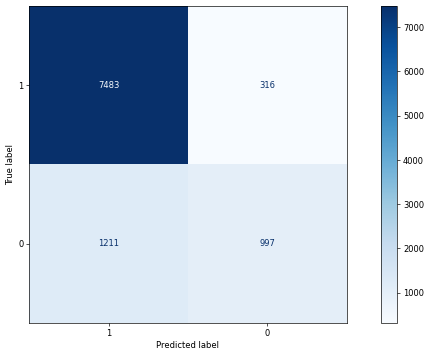

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    knn, X_eval, y_eval, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax
)
plt.show()

## Curva ROC

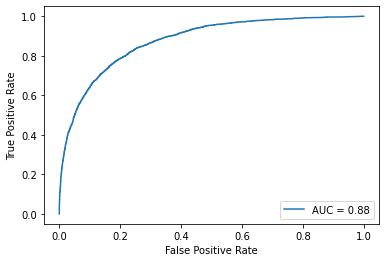

In [9]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

# Predicciones finales

In [ ]:
X_train1 = preprocessing_knn_standard(X_train)

knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=100, weights='distance')
knn.fit(X_train1, y_train)

df_pred = pd.read_csv("pred.csv")
df_pred_preprocess = basic_preprocessing(df_pred, prediction_dataset=True)
df_pred_preprocess = fill_numerical_missings(df_pred_preprocess, X_train)
df_pred_preprocess = df_pred_preprocess.drop(columns = ['id'])
df_pred_preprocess = preprocessing_knn_standard(df_pred_preprocess)

y_pred_final = knn.predict(df_pred_preprocess)
df_pred_final = pd.DataFrame({'id': df_pred['id'], 'llovieron_hamburguesas_al_dia_siguiente': y_pred_final})
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 1, 'llovieron_hamburguesas_al_dia_siguiente'] = 'si'
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 0, 'llovieron_hamburguesas_al_dia_siguiente'] = 'no'

In [17]:
df_pred_final.to_csv('predicciones/knn.csv', index=False)